## **Import Library**

In [1]:
import os
import random
import shutil
import hashlib
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_recall_curve, roc_curve, auc, precision_score, recall_score, roc_auc_score
from PIL import Image


# **Data Preprocessing and Data Split**

    Data Checking and Cleaning 

Found 3296 images belonging to 2 classes.
Class labels:
 - benign: 0
 - malignant: 1
Number of samples per class: {'benign': 1800, 'malignant': 1496}
Most common resolution: [224 224]
No issues found in the dataset.


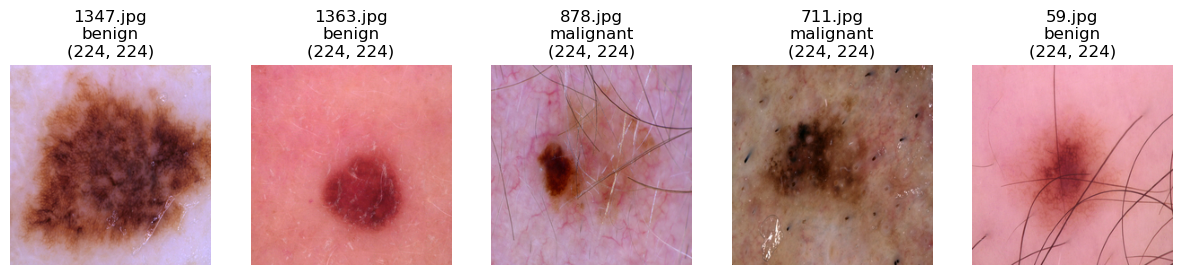

In [2]:

def analyze_dataset(data_cleaning_path):
    datagen = ImageDataGenerator()
    data_flow = datagen.flow_from_directory(data_cleaning_path, target_size=(256, 256), class_mode='binary')
    class_indices = data_flow.class_indices
    classes = list(class_indices.keys())
    num_classes = len(classes)
    class_counts = {}
    resolutions = []
    for class_name in classes:
        class_path = os.path.join(data_cleaning_path, class_name)
        class_counts[class_name] = 0

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                with Image.open(image_path) as img:
                    resolutions.append(img.size) 
                    class_counts[class_name] += 1
            except IOError:
                print(f"Cannot open image: {image_path}")
    resolutions = np.array(resolutions)
    unique_resolutions, counts = np.unique(resolutions, axis=0, return_counts=True)
    most_common_resolution = unique_resolutions[np.argmax(counts)]

    print("Class labels:")
    for class_name, label in class_indices.items():
        print(f" - {class_name}: {label}")

    return class_counts, most_common_resolution

def get_image_hash(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def check_corrupted(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return False
    except (IOError, SyntaxError):
        return True

def check_dataset(directory):
    hashes = set()
    class_counts = {}
    issues_found = False

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        class_counts[class_name] = 0

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

         
            image_hash = get_image_hash(image_path)
            if image_hash in hashes:
                print(f"Duplicate image found: {image_path}")
                issues_found = True
                continue
            hashes.add(image_hash)

   
            if check_corrupted(image_path):
                print(f"Corrupted image found: {image_path}")
                issues_found = True
                continue

            class_counts[class_name] += 1
    min_count = min(class_counts.values())
    max_count = max(class_counts.values())
    if max_count > 1.5 * min_count: 
        print("Class imbalance detected.")
        issues_found = True

    return issues_found

def display_sample_images_with_info(directory, num_images=5):
    images = []
    labels = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        image_files = os.listdir(class_path)
        images += [os.path.join(class_path, file) for file in image_files]
        labels += [class_name for _ in image_files]

    selected_indices = random.sample(range(len(images)), num_images)
    sample_images = [images[i] for i in selected_indices]
    sample_labels = [labels[i] for i in selected_indices]

    plt.figure(figsize=(15, 3))
    for i, image_path in enumerate(sample_images):
        img = Image.open(image_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(image_path)+'\n'+f'{sample_labels[i]}\n{img.size}')
        plt.axis('off')
    
    plt.show()

data_cleaning_path = 'dataset\original_data'  
class_counts, most_common_resolution = analyze_dataset(data_cleaning_path)

print("Number of samples per class:", class_counts)
print("Most common resolution:", most_common_resolution)
if not check_dataset(data_cleaning_path):
    print("No issues found in the dataset.")
display_sample_images_with_info(data_cleaning_path)


    Data augmentation

In [3]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def copy_original_images(source_dir, target_dir, class_name):

    source_class_dir = os.path.join(source_dir, class_name)
    target_class_dir = os.path.join(target_dir, class_name)

    if not os.path.exists(target_class_dir):
        os.makedirs(target_class_dir)

    for filename in os.listdir(source_class_dir):
        source_path = os.path.join(source_class_dir, filename)
        target_path = os.path.join(target_class_dir, filename)
        shutil.copy2(source_path, target_path)

def augment_images(source_dir, class_name, target_dir, target_count, generator):

    source_class_dir = os.path.join(source_dir, class_name)
    target_class_dir = os.path.join(target_dir, class_name)
    
    if not os.path.exists(target_class_dir):
        os.makedirs(target_class_dir)

    current_count = len(os.listdir(source_class_dir))
    required_count = target_count - current_count
    print(f"{class_name}: There ara currently {current_count} images, and {required_count} images need to be enhanced.")

    if required_count <= 0:
        print(f"{class_name}: The target number has been reached and no enhancement is required.")
        return

    flow = generator.flow_from_directory(
        directory=source_dir,
        classes=[class_name],
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',  
        save_to_dir=target_class_dir,
        save_prefix='aug_',
        save_format='png'
    )

    num_batches = required_count // 32 + (1 if required_count % 32 > 0 else 0)
    for i in range(num_batches):
        next(flow)
        if len(os.listdir(target_class_dir)) >= target_count:
            break

original_dataset_dir = 'dataset/original_data'
augmented_dataset_dir = 'dataset/augmented_dataset'


for class_name in ['benign', 'malignant']:
    copy_original_images(original_dataset_dir, augmented_dataset_dir, class_name)

for class_name in ['benign', 'malignant']:
    augment_images(original_dataset_dir, class_name, augmented_dataset_dir, 5000, datagen)

print("Done!")


benign: There ara currently 1800 images, and 3200 images need to be enhanced.
Found 1800 images belonging to 1 classes.
malignant: There ara currently 1496 images, and 3504 images need to be enhanced.
Found 1496 images belonging to 1 classes.
Done!


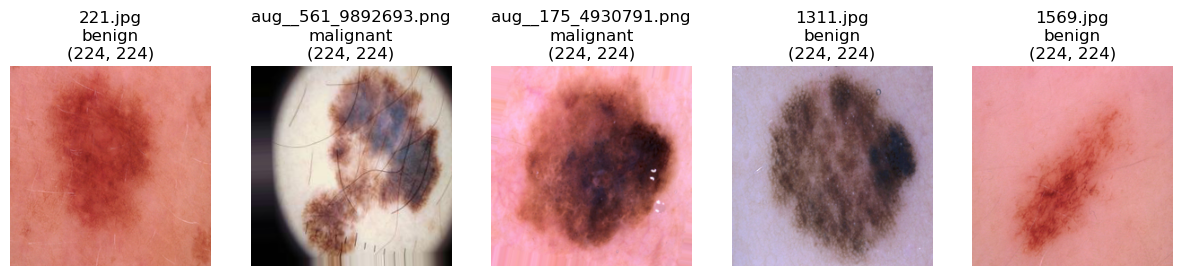

In [4]:
data_dir = 'dataset/augmented_dataset'  

def display_sample_images_with_info_after_augmentation(directory, num_images=5):
    images = []
    labels = []

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        image_files = os.listdir(class_path)
        images += [os.path.join(class_path, file) for file in image_files]
        labels += [class_name for _ in image_files]

    selected_indices = random.sample(range(len(images)), num_images)
    sample_images = [images[i] for i in selected_indices]
    sample_labels = [labels[i] for i in selected_indices]

    plt.figure(figsize=(15, 3))
    for i, image_path in enumerate(sample_images):
        img = Image.open(image_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(image_path)+'\n'+f'{sample_labels[i]}\n{img.size}')
        plt.axis('off')
    
    plt.show()
display_sample_images_with_info_after_augmentation(data_dir)

    Data Split

In [5]:
def split_dataset(original_dir, target_dir, train_ratio=0.8, val_ratio=0.1):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        os.makedirs(os.path.join(target_dir, 'train'))
        os.makedirs(os.path.join(target_dir, 'validation'))
        os.makedirs(os.path.join(target_dir, 'test'))

    classes = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

    for cls in classes:
        os.makedirs(os.path.join(target_dir, 'train', cls))
        os.makedirs(os.path.join(target_dir, 'validation', cls))
        os.makedirs(os.path.join(target_dir, 'test', cls))

        all_images = os.listdir(os.path.join(original_dir, cls))
        np.random.shuffle(all_images)

        train_end = int(len(all_images) * train_ratio)
        val_end = train_end + int(len(all_images) * val_ratio)

        for i, img in enumerate(all_images):
            if i < train_end:
                subset = 'train'
            elif i < val_end:
                subset = 'validation'
            else:
                subset = 'test'

            src = os.path.join(original_dir, cls, img)
            dst = os.path.join(target_dir, subset, cls, img)
            shutil.copy(src, dst)

def count_images_in_subfolders(directory):
    counts = {}
    for subset in ['train', 'validation', 'test']:
        subset_path = os.path.join(directory, subset)
        for cls in os.listdir(subset_path):
            class_path = os.path.join(subset_path, cls)
            if os.path.isdir(class_path):
                count = len(os.listdir(class_path))
                counts[f"{subset}/{cls}"] = count
    return counts


augmented_dataset_dir = "dataset/augmented_dataset"
splited_dataset_dir = "dataset/splited_dataset"

split_dataset(augmented_dataset_dir, splited_dataset_dir)

train/benign: 4006 images
train/malignant: 4025 images
validation/benign: 500 images
validation/malignant: 503 images
test/benign: 502 images
test/malignant: 504 images


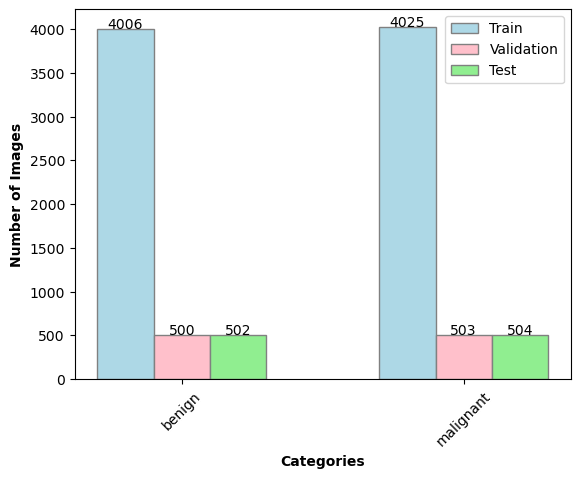

In [6]:
def count_images_in_subfolders(directory):
    counts = {}
    for subset in ['train', 'validation', 'test']:
        subset_path = os.path.join(directory, subset)
        for cls in os.listdir(subset_path):
            class_path = os.path.join(subset_path, cls)
            if os.path.isdir(class_path):
                count = len(os.listdir(class_path))
                counts[f"{subset}/{cls}"] = count
    return counts

counts = count_images_in_subfolders(splited_dataset_dir)
for key, count in counts.items():
    print(f"{key}: {count} images")

def visualize_data_splits(train_dir, validation_dir, test_dir):
    categories = set()
    data = {'train': {}, 'validation': {}, 'test': {}}

    for dataset, directory in zip(['train', 'validation', 'test'], [train_dir, validation_dir, test_dir]):
        for category in os.listdir(directory):
            category_path = os.path.join(directory, category)
            if os.path.isdir(category_path):
                categories.add(category)
                data[dataset][category] = len(os.listdir(category_path))

    categories = sorted(list(categories))
    
    bar_width = 0.2
    r1 = np.arange(len(categories))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.bar(r1, [data['train'].get(category, 0) for category in categories], color='#ADD8E6', width=bar_width, edgecolor='grey', label='Train')
    plt.bar(r2, [data['validation'].get(category, 0) for category in categories], color='#FFC0CB', width=bar_width, edgecolor='grey', label='Validation')
    plt.bar(r3, [data['test'].get(category, 0) for category in categories], color='#90EE90', width=bar_width, edgecolor='grey', label='Test')

    plt.xlabel('Categories', fontweight='bold')
    plt.ylabel('Number of Images', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(categories))], categories, rotation=45)
    plt.legend()

    def add_labels(r, dataset):
        for i in range(len(categories)):
            plt.text(x=r[i], y=data[dataset][categories[i]] + 5, s=data[dataset][categories[i]], ha='center')

    add_labels(r1, 'train')
    add_labels(r2, 'validation')
    add_labels(r3, 'test')

    plt.show()

splited_dataset_dir = "dataset/splited_dataset"
train_dir = os.path.join(splited_dataset_dir, 'train')
validation_dir = os.path.join(splited_dataset_dir, 'validation')
test_dir = os.path.join(splited_dataset_dir, 'test')

visualize_data_splits(train_dir, validation_dir, test_dir)
